In [1]:
%matplotlib inline

In [15]:
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from math import factorial
import random
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import os 
from os.path import join
import glob
from math import factorial
ttype =  torch.FloatTensor
print(ttype)

# deep_iSITH is being used here, not deep_sith
from isith import iSITH
from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")

<class 'torch.FloatTensor'>


In [16]:
test_isith = iSITH(tau_min=1.0, tau_max=500, ntau=200, buff_max=500, ttype=ttype, g=0).cuda()
test_input = ttype([1,0,0,0,0,0,0,1,1,1,1,0,0,0,0]).reshape(1,1,1,-1, 1)

# setup testing signals

In [17]:
repeats = 1
test_input1 = test_input.repeat(1,1,1,1,repeats).view(1,1,1,-1)
print(test_input1.shape)

torch.Size([1, 1, 1, 15])


In [18]:

repeats = 2
test_input2 = test_input.repeat(1,1,1,1,repeats).view(1,1,1,-1)
print(test_input2.shape)

torch.Size([1, 1, 1, 30])


# run signals

In [19]:
out1 = test_isith(test_input1[:, :, :, :])
print(out1.shape)

torch.Size([1, 200, 1, 15])


In [20]:
out2 = test_isith(test_input2[:, :, :, :])
print(out2.shape)

torch.Size([1, 200, 1, 30])


# plot output

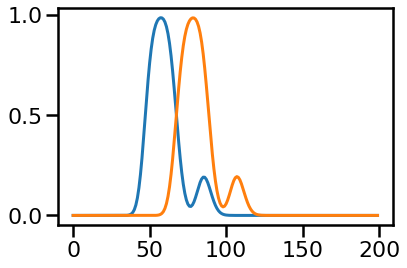

In [21]:
plt.plot(out1[0, :, 0, -1].detach().cpu());
plt.plot(out2[0, :, 0, -1].detach().cpu());

# Filter visualizations

In [485]:
test_isith = iSITH(tau_min=1.0, tau_max=1500, ntau=500, buff_max=3500, ttype=ttype, g=1).cuda()

In [281]:
import time

torch.Size([1, 1, 1, 750])


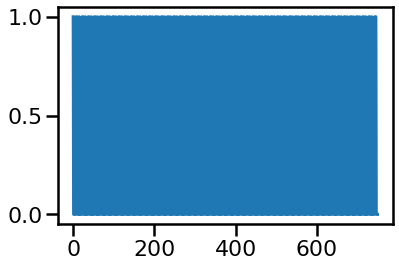

In [493]:
inp = test_input1.repeat(1,1,1,50)
print(inp.shape)
plt.plot(inp[0,0,0].detach());

In [496]:
%%timeit
out1 = torch.conv2d(inp, test_isith.filters[:, :, :, -inp.shape[-1]:], padding=[0, test_isith.filters[:, :, :, -inp.shape[-1]:].shape[-1]])[:, :, :, 2:inp.shape[-1]+2]*test_isith.dt*test_isith.k/(test_isith.k+1)


23.6 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [495]:
%%timeit
out1 = torch.conv2d(inp, test_isith.filters[:, :, :, :], padding=[0, test_isith.filters[:, :, :, :].shape[-1]])[:, :, :, 2:inp.shape[-1]+2]*test_isith.dt*test_isith.k/(test_isith.k+1)


97.6 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [498]:
i = 0

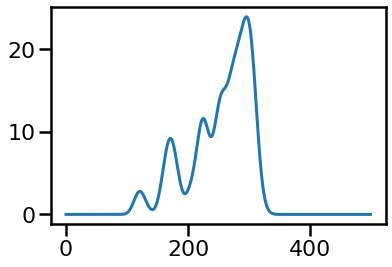

In [594]:
plt.plot(out1.detach().cpu()[0, :, 0, i]);
i+=1
#plt.plot(out1.detach().cpu()[0, :, 0, -1]);

In [462]:
%%timeit
out2 = torch.conv2d(inp, test_isith.filters[:, :, :, -inp.shape[-1]-2:], padding=[0, inp.shape[-1]])


253 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


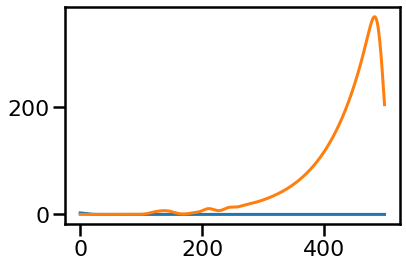

In [292]:
plt.plot(out2.detach().cpu()[0, :, 0, 0]);
plt.plot(out2.detach().cpu()[0, :, 0, inp.shape[-1]]);

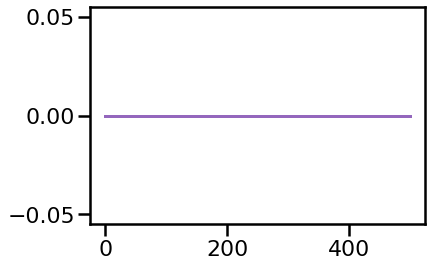

In [278]:
plt.plot((out1-out2[:, :, :, :15]).detach()[0, :, 0, :]);

In [147]:
test_out = out[0, :, 0, :]
print(test_out.shape)

torch.Size([500, 15])


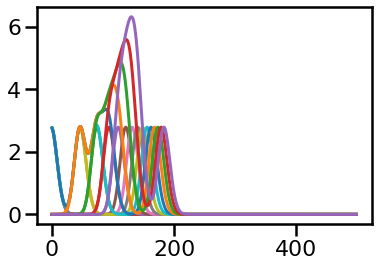

In [385]:
# This is important as we are trying to match the signal here. 

plt.plot(test_out);

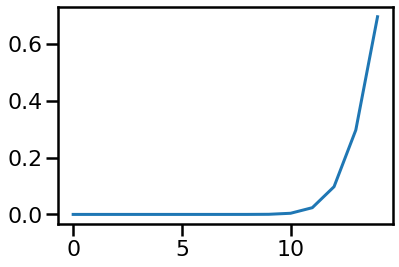

In [435]:
plt.plot(test_out[200]);

# Filters visualization

In [334]:
test_isith = iSITH(tau_min=1.0, tau_max=1500, ntau=500, buff_max=3500, ttype=ttype, g=1).cuda()

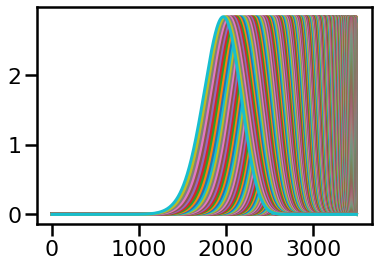

In [335]:
plt.plot(test_isith.filters[:, 0, 0, :].detach().T);

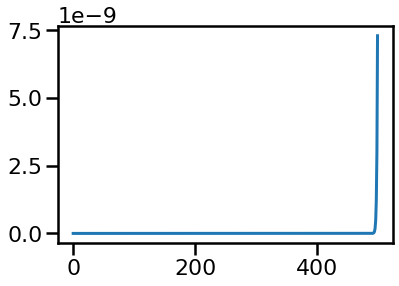

In [432]:
plt.plot(test_isith.filters[:, 0, 0, 200].detach().T);

In [464]:
lengths = []
cut_offs = []
new_filts = []
filt_cut = 10e-10
min_filt = 30
for i in range(test_isith.filters.shape[0]):
    
    filt = test_isith.filters[i:i+1, 0, 0, :].detach().T
    cut_pos = (filt[filt<filt_cut].shape[0] - filt[filt<filt_cut].argmax())
    filt2 = filt[filt >= filt_cut]
    if filt2.shape[0] < min_filt:
        filt = filt[-min_filt:, 0]
        cut_pos = 0
    else:
        filt = filt2
    new_filts.append(filt.unsqueeze(0).unsqueeze(0).clone())
    cut_offs.append(cut_pos)
    lengths.append(filt.shape)
"""for i in range(len(new_filts)):
    new_filts[i] = nn.functional.pad(new_filts[i], (0, new_filts[-1].shape[0] - new_filts[i].shape[0])).unsqueeze(0)
    plt.plot(new_filts[i].detach()[0])
    """

'for i in range(len(new_filts)):\n    new_filts[i] = nn.functional.pad(new_filts[i], (0, new_filts[-1].shape[0] - new_filts[i].shape[0])).unsqueeze(0)\n    plt.plot(new_filts[i].detach()[0])\n    '

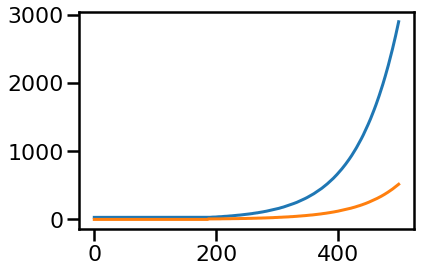

In [465]:
plt.plot(lengths)
plt.plot(cut_offs)

In [466]:
new_filts[-1].shape

torch.Size([1, 1, 2895])

Text(0, 0.5, 'length of filtered filter')

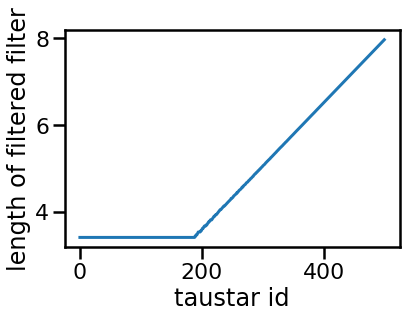

In [467]:
plt.plot(np.log(lengths))
plt.xlabel('taustar id')
plt.ylabel('length of filtered filter')


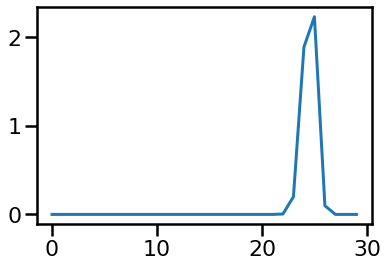

In [468]:
plt.plot(new_filts[-400][0,0]);

In [469]:
%%timeit
ot = nn.functional.conv1d(test_input1[:, 0], 
                          new_filts[200], padding=new_filts[200].shape[-1]).detach()


60.1 µs ± 1.86 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


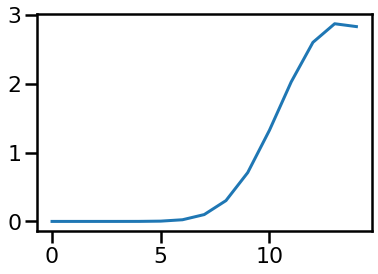

In [470]:
inp = test_input1[:,:,:,:]#.repeat(1,1,1,100)

plt.plot(nn.functional.conv1d(inp[0], new_filts[-400][-inp.shape[-1]:], padding=new_filts[-400][-inp.shape[-1]:].shape[-1])[0,0,:inp.shape[-1]].detach())

In [476]:
%%timeit
outs = torch.cat([nn.functional.pad(nn.functional.conv1d(inp[0], 
                                               new_filts[f], 
                                               padding=new_filts[f].shape[-1]),
                          pad=[cut_offs[f], 0])[:,:,:inp.shape[-1]] for f in range(len(new_filts))])

282 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


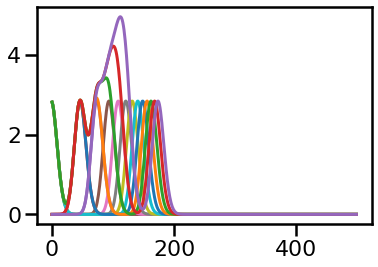

In [475]:
plt.plot(outs.detach()[:, 0, :]);

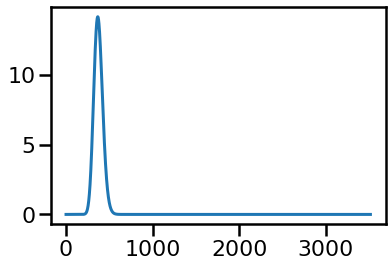

In [473]:
plt.plot(ot[0,0,:].detach())

In [322]:
test_isith.filters.shape

torch.Size([500, 1, 1, 3500])

In [325]:
%%timeit
ot = nn.functional.conv1d(test_input1[:, 0], 
                          test_isith.filters[400], padding=test_isith.filters[400].shape[-1]).detach()

10.5 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [137]:
filt = test_isith.filters[300:300+1, 0, 0, :].detach()[0]
print(filt.shape)


torch.Size([3500])


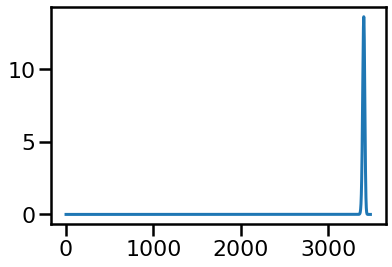

In [138]:
plt.plot(nn.functional.conv1d(filt.unsqueeze(0).unsqueeze(0),test_input1[:, 0]).detach()[0,0])

torch.Size([1, 1, 2374])